In [1]:
import os
import sys
sys.path.append('utils')
import pandas as pd
import numpy as np
from pandas.tseries.offsets import Day, Minute, Hour
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
from dataset.spot import SlidingWindow, SPOT
import math

% matplotlib inline

In [2]:
def mae(pred, y_true, mode='default'):
    if mode == 'max':
        out = np.abs(pred.reshape(-1, 24).max(axis=-1) - y_true.reshape(-1, 24).max(axis=-1)).mean()
    elif mode == 'min':
        out = np.abs(pred.reshape(-1, 24).min(axis=-1) - y_true.reshape(-1, 24).min(axis=-1)).mean()
    else:
        out = np.abs(pred - y_true).mean()
    return out

def rmse(pred, y_true):
    out = np.power((pred - y_true), 2).mean()
    return math.sqrt(out)

def mape(pred, y_true, threshold=1e-2):
    pred.reshape(y_true.shape)
    f = lambda o,c: (math.fabs((o-c) / float(o)))*1.0 if math.fabs(o) > threshold else np.nan
    f = np.vectorize(f)
    error = f(y_true, pred)    
    errorCnts = error.shape[0]-np.sum(np.isnan(error),axis=0)
    error = np.nan_to_num(error)
    return np.sum(error, axis=0) / errorCnts

In [3]:
y_true = SPOT["2016-01-01":"2016-06-30"].values
y_true

array([22.39, 20.59, 16.81, ..., 27.72, 29.36, 24.69])

In [3]:
# online version
sw = SlidingWindow('2015-12-31')
start_date = "2016-01-01"
dt = pd.to_datetime(start_date)
track_dates = []
predictions = []

for _ in trange(182):
    track_dates.append(dt)
    Xtrain = sw.X
    Ytrain = sw.Y
    
    scaler = StandardScaler().fit(Xtrain)
    Xtrain = scaler.transform(Xtrain)
    
#     krr = KernelRidge(alpha=3.3386975245333717, degree=3, kernel='poly').fit(Xtrain, Ytrain)
    krr = KernelRidge(alpha=0.3386975245333717, degree=3, kernel='poly').fit(Xtrain, Ytrain)
    Xtest = scaler.transform(np.expand_dims(sw.get_features(dt),axis=0))
    predictions.append(krr.predict(Xtest)[0])
    sw.update_training(dt)
    dt+=Day(1)

100%|██████████| 182/182 [00:33<00:00,  5.24it/s]


In [4]:
track_dates[-1]

Timestamp('2016-06-30 00:00:00')

In [5]:
online_prediction = np.array(predictions).flatten()

In [6]:
np.abs(y_true-online_prediction).mean()

3.3908449112146237

In [7]:
len(y_true)/182.

24.0

In [8]:
autoregressive_results = pd.DataFrame()
autoregressive_results['ground_truth'] = y_true
autoregressive_results['krr_online'] = online_prediction
autoregressive_results.index = SPOT["2016-01-01":"2016-06-30"].index

In [9]:
autoregressive_results

,ground_truth,krr_online
datetime,,
2016-01-01 00:30:00,22.39,23.960830
2016-01-01 01:30:00,20.59,19.008754
2016-01-01 02:30:00,16.81,13.417379
2016-01-01 03:30:00,17.41,16.362612
2016-01-01 04:30:00,17.02,21.324665
2016-01-01 05:30:00,15.86,17.756178
2016-01-01 06:30:00,18.16,13.811356
2016-01-01 07:30:00,17.73,18.876505
2016-01-01 08:30:00,19.77,27.213247


In [10]:
online_prediction

array([23.96082977, 19.00875393, 13.41737923, ..., 31.03696702,
       27.44502864, 23.19807054])

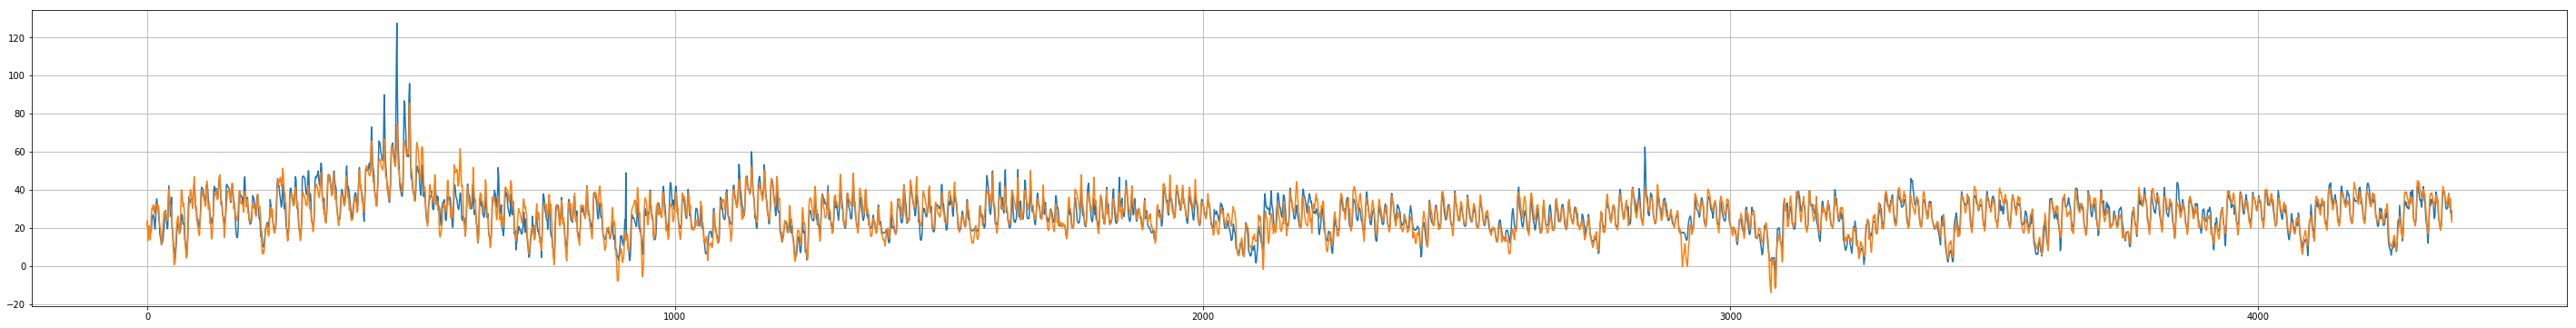

In [12]:
# plot
plt.figure(figsize=(50,6))
plt.plot(y_true)
plt.plot(online_prediction)
plt.grid()

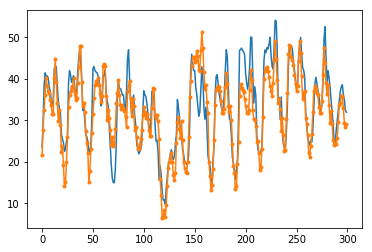

In [13]:
plt.plot(y_true[100:400])
plt.plot(online_prediction[100:400],'.-')

In [53]:
# offline version
sw = SlidingWindow('2015-12-31')
start_date = "2016-01-01"
dt = pd.to_datetime(start_date)
track_dates = []
predictions = []

Xtrain = sw.X
Ytrain = sw.Y
    
scaler = StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)

# krr = KernelRidge(alpha=3.3386975245333717, degree=3, kernel='poly').fit(Xtrain, Ytrain)
krr = KernelRidge(alpha=0.3386975245333717, degree=3, kernel='poly').fit(Xtrain, Ytrain)

for _ in trange(182):
    track_dates.append(dt)

    Xtest = scaler.transform(np.expand_dims(sw.get_features(dt),axis=0))
    predictions.append(krr.predict(Xtest)[0])
    dt+=Day(1)

100%|██████████| 182/182 [00:00<00:00, 837.76it/s]


In [43]:
offline_prediction = np.array(predictions).flatten()

In [44]:
np.abs(y_true-offline_prediction).mean()

3.6541027675227893

In [45]:
autoregressive_results['krr_offline'] = offline_prediction

In [46]:
autoregressive_results.to_csv("autoregressive.csv")

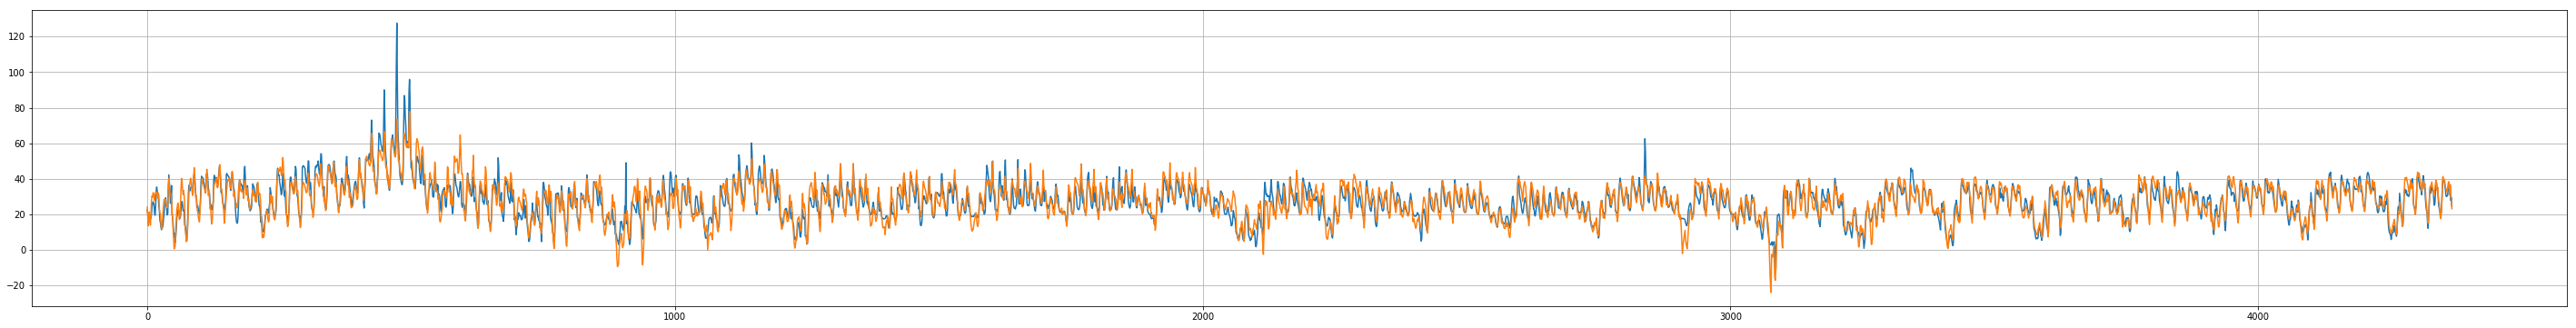

In [54]:
# plot
plt.figure(figsize=(50,6))
plt.plot(y_true)
plt.plot(offline_prediction)
plt.grid()

In [55]:
mae(offline_prediction, y_true), mae(offline_prediction, y_true, mode='max'), mae(offline_prediction, y_true, mode='min'), rmse(offline_prediction, y_true), mape(offline_prediction, y_true)

(3.6541027675227893,
 4.296087658131683,
 3.4974265420506985,
 4.942207844462718,
 0.1752914976569374)

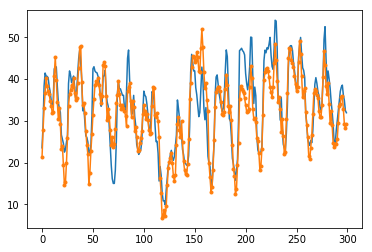

In [20]:
plt.plot(y_true[100:400])
plt.plot(offline_prediction[100:400],'.-')

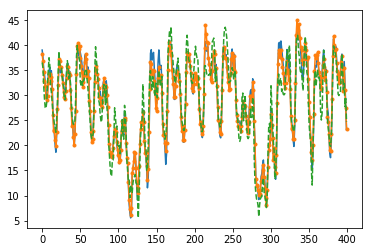

In [21]:
plt.plot(offline_prediction[-400:])
plt.plot(online_prediction[-400:],'.-')
plt.plot(y_true[-400:],'--')

In [22]:
pd.Series(online_prediction-offline_prediction).abs().mean()

1.0638423827358743

In [85]:
# self-gen version
W = 7
sw = SlidingWindow('2015-12-31',W=7)
start_date = "2016-06-24"
dt = pd.to_datetime(start_date)
track_dates = []
predictions = []

Xtrain = sw.X
Ytrain = sw.Y
    
scaler = StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)

# krr = KernelRidge(alpha=3.3386975245333717, degree=3, kernel='poly').fit(Xtrain, Ytrain)
# krr = KernelRidge(alpha=0.3386975245333717, degree=3, kernel='poly').fit(Xtrain, Ytrain)
krr = KernelRidge(alpha=0, degree=3, kernel='poly').fit(Xtrain, Ytrain)

track_dates.append(dt)
features = sw.get_features(dt)
Xtest = scaler.transform(np.expand_dims(features,axis=0))
pred = krr.predict(Xtest)[0]
predictions.append(pred)
dt+=Day(1)

for _ in trange(61):
    track_dates.append(dt)
    
    features = sw.get_features(dt)
    features[144:168] = pred

    Xtest = scaler.transform(np.expand_dims(features,axis=0))
    pred = krr.predict(Xtest)[0]
    predictions.append(pred)
    dt+=Day(1)

100%|██████████| 61/61 [00:00<00:00, 721.53it/s]


In [86]:
predictions[0]

array([24.53491208, 20.48572258, 20.37730581, 23.985759  , 32.29869225,
       39.76947324, 44.22417863, 45.21760293, 42.21099568, 42.38977649,
       39.6906689 , 37.09170963, 34.93230727, 33.12043811, 34.17840913,
       38.60997223, 40.69174472, 42.61093176, 38.5457724 , 38.53535947,
       40.82675475, 41.10445672, 31.00672175, 27.99008742])

In [87]:
self_prediction = np.array(predictions[-62:]).flatten()

In [88]:
self_prediction.shape

(1488,)

In [91]:
y_true = SPOT["2016-07-01":"2016-08-31"].values
mae(self_prediction, y_true), rmse(self_prediction, y_true), mape(self_prediction, y_true)

(5.954206075061119, 7.3974084213249025, 0.22108739269933114)

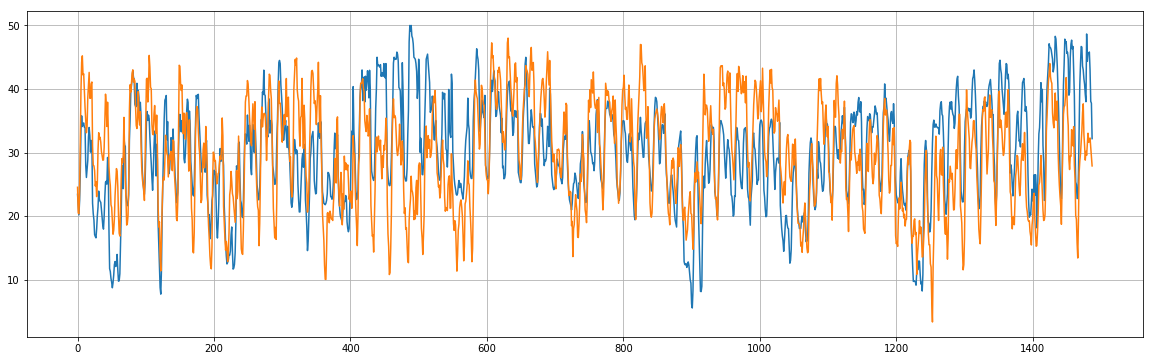

In [92]:
# plot
plt.figure(figsize=(20,6))
plt.plot(y_true)
plt.plot(self_prediction)
plt.grid()

In [93]:
mae(self_prediction[:14*24], y_true[:14*24]), rmse(self_prediction[:14*24], y_true[:14*24]), mape(self_prediction[:14*24], y_true[:14*24])

(5.190822635809066, 6.31203430230213, 0.23358431178617495)